# 환경 구성

### 다운로드

In [1]:
# !pip install transformers

In [2]:
# !pip install nlpaug

### import

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

# 자연어 분석
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop=set(stopwords.words('english'))
from textblob import TextBlob  ## for sentiment

# 파이토치!
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from transformers import BertModel
from torch.optim import Adam

# 시각화!
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 증강!
import nlpaug.augmenter.sentence as nas
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.word.context_word_embs as nawcwe
import nlpaug.augmenter.word.word_embs as nawwe
import nlpaug.augmenter.word.spelling as naws

import warnings
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
cd /content/drive/MyDrive/기타/발화자 감정인식

/content/drive/MyDrive/기타/발화자 감정인식


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Hyperparameter Setting

In [6]:
CFG = {
    'EPOCHS': 3,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':8,
    'SEED':41
}

### Fixed RandomSeed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### Data Load

In [8]:
info = pd.read_csv('./data_info.csv',encoding='cp949')
info.head()

,feature,information,type
0,ID,고유번호,object
1,Utterance,발화문,object
2,Speaker,발화자,object
3,Dialogue_ID,Dialogue 구분 번호,int
4,Target,감정,object


In [9]:
train = pd.read_csv('./text_aug.csv')

In [10]:
train.head()

,Utterance,Target,Speaker,Dialogue_ID
0,also I was the point person on my company’s tr...,neutral,Chandler,0
1,You must’ve had your hands full.,neutral,The Interviewer,0
2,That I did. That I did.,neutral,Chandler,0
3,So let’s talk a little bit about your duties.,neutral,The Interviewer,0
4,My duties? All right.,surprise,Chandler,0


# 모델 학습 및 분류

### Feature Engineering

In [11]:
train.head()

,Utterance,Target,Speaker,Dialogue_ID
0,also I was the point person on my company’s tr...,neutral,Chandler,0
1,You must’ve had your hands full.,neutral,The Interviewer,0
2,That I did. That I did.,neutral,Chandler,0
3,So let’s talk a little bit about your duties.,neutral,The Interviewer,0
4,My duties? All right.,surprise,Chandler,0


In [12]:
# 단순히 생각했을 때 ?! 등의 단어는 감정을 잘 드러낼 것 같음
train['emoji'] = np.where(train['Utterance'].str.contains('\?') | train['Utterance'].str.contains('\!'), '0','1')

Target,anger,disgust,fear,joy,neutral,sadness,surprise
emoji,,,,,,,
0,0.222228,0.032174,0.036746,0.294536,0.080210,0.069372,0.264732
1,0.112677,0.061290,0.053974,0.244714,0.293425,0.178339,0.055580


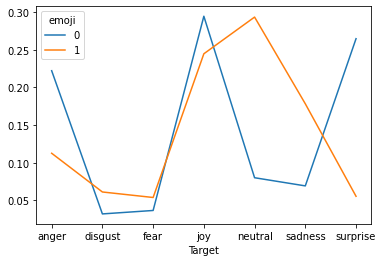

In [13]:
display((train.groupby(['emoji','Target']).count() / train.groupby(['emoji']).count()).unstack()['Utterance'])
(train.groupby(['emoji','Target']).count() / train.groupby(['emoji']).count()).unstack()['Utterance'].T.plot()

In [14]:
import re

In [15]:
def count_words(text):
    return len(text.split())

In [16]:
def count_unique_words(text):
    return len(set(text.split()))

In [17]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [18]:
train['word_count'] = train["Utterance"].apply(lambda x:count_words(x))
train['stopword_count'] = train["Utterance"].apply(lambda x:count_stopwords(x))
train['unique_word_count'] = train["Utterance"].apply(lambda x:count_unique_words(x))

In [19]:
train['unique_vs_words'] = train['unique_word_count']/train['word_count']
train['stopwords_vs_words'] = train['stopword_count']/train['word_count']

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28925 entries, 0 to 28924
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Utterance           28925 non-null  object 
 1   Target              28925 non-null  object 
 2   Speaker             28925 non-null  object 
 3   Dialogue_ID         28925 non-null  int64  
 4   emoji               28925 non-null  object 
 5   word_count          28925 non-null  int64  
 6   stopword_count      28925 non-null  int64  
 7   unique_word_count   28925 non-null  int64  
 8   unique_vs_words     28925 non-null  float64
 9   stopwords_vs_words  28925 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 2.2+ MB


In [21]:
train["Dialogue_ID"] = train["Dialogue_ID"].astype(int)

In [22]:
train.head()

,Utterance,Target,Speaker,Dialogue_ID,emoji,word_count,stopword_count,unique_word_count,unique_vs_words,stopwords_vs_words
0,also I was the point person on my company’s tr...,neutral,Chandler,0,1,16,8,15,0.9375,0.500000
1,You must’ve had your hands full.,neutral,The Interviewer,0,1,6,3,6,1.0000,0.500000
2,That I did. That I did.,neutral,Chandler,0,1,6,2,3,0.5000,0.333333
3,So let’s talk a little bit about your duties.,neutral,The Interviewer,0,1,9,4,9,1.0000,0.444444
4,My duties? All right.,surprise,Chandler,0,0,4,0,4,1.0000,0.000000


In [23]:
display((train.groupby(['stopword_count','Target']).count() / train.groupby(['stopword_count']).count()).unstack()['Utterance'])

Target,anger,disgust,fear,joy,neutral,sadness,surprise
stopword_count,,,,,,,
0,0.114551,0.023220,0.029412,0.296956,0.271672,0.052116,0.212074
1,0.141049,0.034659,0.031646,0.295359,0.183846,0.076552,0.236890
2,0.147493,0.036511,0.037380,0.271516,0.190669,0.085772,0.230658
3,0.169739,0.038779,0.037508,0.280038,0.175461,0.104577,0.193897
4,0.182773,0.042017,0.042367,0.279412,0.146709,0.114846,0.191877
5,0.182616,0.044296,0.047639,0.267447,0.144170,0.122858,0.190974
6,0.215667,0.050570,0.044621,0.263262,0.124442,0.139316,0.162122
7,0.219674,0.043452,0.045263,0.269161,0.130960,0.140616,0.150875
8,0.193303,0.057839,0.064688,0.267123,0.121005,0.158295,0.137747


In [24]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_stopwords = nltk.corpus.stopwords.words("english")
    
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [25]:
train["Utterance_clean"] = train["Utterance"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))

In [26]:
print(train["Utterance"].iloc[0], " --> ", train["Utterance_clean"].iloc[0])

also I was the point person on my company’s transition from the KL-5 to GR-6 system.  -->  also point person company transition kl5 gr6 system


In [27]:
train["sentiment"] = train['Utterance'].apply(lambda x: TextBlob(x).sentiment.polarity)
train.head()

,Utterance,Target,Speaker,Dialogue_ID,emoji,word_count,stopword_count,unique_word_count,unique_vs_words,stopwords_vs_words,Utterance_clean,sentiment
0,also I was the point person on my company’s tr...,neutral,Chandler,0,1,16,8,15,0.9375,0.500000,also point person company transition kl5 gr6 s...,0.000000
1,You must’ve had your hands full.,neutral,The Interviewer,0,1,6,3,6,1.0000,0.500000,mustve hand full,0.350000
2,That I did. That I did.,neutral,Chandler,0,1,6,2,3,0.5000,0.333333,,0.000000
3,So let’s talk a little bit about your duties.,neutral,The Interviewer,0,1,9,4,9,1.0000,0.444444,let talk little bit duty,-0.187500
4,My duties? All right.,surprise,Chandler,0,0,4,0,4,1.0000,0.000000,duty right,0.285714


In [28]:
train["subjectivity"] = train['Utterance'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
train.head()

,Utterance,Target,Speaker,Dialogue_ID,emoji,word_count,stopword_count,unique_word_count,unique_vs_words,stopwords_vs_words,Utterance_clean,sentiment,subjectivity
0,also I was the point person on my company’s tr...,neutral,Chandler,0,1,16,8,15,0.9375,0.500000,also point person company transition kl5 gr6 s...,0.000000,0.000000
1,You must’ve had your hands full.,neutral,The Interviewer,0,1,6,3,6,1.0000,0.500000,mustve hand full,0.350000,0.550000
2,That I did. That I did.,neutral,Chandler,0,1,6,2,3,0.5000,0.333333,,0.000000,0.000000
3,So let’s talk a little bit about your duties.,neutral,The Interviewer,0,1,9,4,9,1.0000,0.444444,let talk little bit duty,-0.187500,0.500000
4,My duties? All right.,surprise,Chandler,0,0,4,0,4,1.0000,0.000000,duty right,0.285714,0.535714


In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
senti_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [30]:
senti_scores = train['Utterance'].apply(lambda x: senti_analyzer.polarity_scores(x))

In [31]:
senti_scores_df = pd.DataFrame(senti_scores.to_dict())

In [32]:
senti_scores_df = senti_scores_df.T

In [33]:
senti_scores_df.shape

(28925, 4)

In [34]:
for arg in senti_scores_df.columns:
    train[arg] = senti_scores_df[arg]

In [35]:
train.head()

,Utterance,Target,Speaker,Dialogue_ID,emoji,word_count,stopword_count,unique_word_count,unique_vs_words,stopwords_vs_words,Utterance_clean,sentiment,subjectivity,neg,neu,pos,compound
0,also I was the point person on my company’s tr...,neutral,Chandler,0,1,16,8,15,0.9375,0.500000,also point person company transition kl5 gr6 s...,0.000000,0.000000,0.0,1.0,0.0,0.0
1,You must’ve had your hands full.,neutral,The Interviewer,0,1,6,3,6,1.0000,0.500000,mustve hand full,0.350000,0.550000,0.0,1.0,0.0,0.0
2,That I did. That I did.,neutral,Chandler,0,1,6,2,3,0.5000,0.333333,,0.000000,0.000000,0.0,1.0,0.0,0.0
3,So let’s talk a little bit about your duties.,neutral,The Interviewer,0,1,9,4,9,1.0000,0.444444,let talk little bit duty,-0.187500,0.500000,0.0,1.0,0.0,0.0
4,My duties? All right.,surprise,Chandler,0,0,4,0,4,1.0000,0.000000,duty right,0.285714,0.535714,0.0,1.0,0.0,0.0


### 워드 임베딩

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
intent_train = train["Utterance"]

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[173,
  1,
  46,
  4,
  746,
  454,
  29,
  17,
  5986,
  5987,
  130,
  4,
  5988,
  1377,
  5,
  5989,
  1751,
  1266],
 [2, 2509, 116, 49, 948, 675],
 [8, 1, 86, 8, 1, 86],
 [15, 604, 260, 7, 98, 573, 58, 49, 3091],
 [17, 3091, 26, 47]]

발화마다 길이가 다르므로, 길이를 통일하기 위하여 문장 길이 파악

문장의 최대 길이 : 81
문장의 평균 길이 : 10.8504753673293


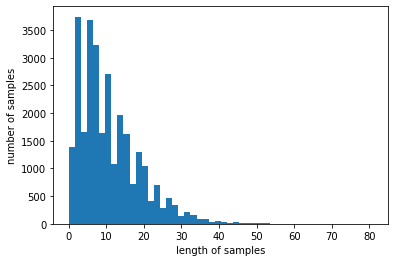

In [39]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [40]:
max_len = 81

intent_train = pad_sequences(sequences, maxlen = max_len)

In [41]:
print('훈련 데이터의 크기(shape):', intent_train.shape)

훈련 데이터의 크기(shape): (28925, 81)


In [42]:
train_np = train[['Dialogue_ID','emoji','word_count','stopword_count','unique_word_count','unique_vs_words','stopwords_vs_words',"sentiment",'neg','neu','pos','compound']].to_numpy()

In [43]:
print('훈련 데이터의 크기(shape):', train_np.shape)

훈련 데이터의 크기(shape): (28925, 12)


In [44]:
intent_train = np.append(intent_train, train_np, axis = 1)

### 머신러닝 학습

In [45]:
# from sklearn.model_selection import train_test_split
# y_data = train["Target"]
# x_train, x_valid, y_train, y_valid = train_test_split(intent_train, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [46]:
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from sklearn.linear_model import SGDClassifier

# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
# clf3 = XGBClassifier(random_state=1)

# eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2),('xgb',clf3)], voting='hard')
# # clf = MultiOutputClassifier(clf2)
# # clf.fit(x_train, y_train)
# eclf1.fit(x_train, y_train)

In [47]:
# val_pred = eclf1.predict(x_valid)

In [48]:
# from sklearn.metrics import f1_score
# from sklearn.metrics import classification_report

# val_score = f1_score(y_valid, val_pred, average='macro')
# print(f'Validation F1 Score: {val_score}')
# print(classification_report(y_valid,val_pred))

# # 0.34 -> utterance, feature engineering(with sentiemnt from textblob)
# # clean data, subjectivity feature는 영향력 없음. 오히려 모델의 복잡성만 향상

# # 0.43 -> utterance, feature engineering(with sentiemnt from textblob, sentiment ratio from nltk.vader)
# # clean data, subjectivity feature는 영향력 없음. 오히려 모델의 복잡성만 향상

### 학습

In [49]:
# # Install the proper version of PyTorch following https://pytorch.org/get-started/locally/
# !pip3 install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchtext==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu113

In [50]:
# !pip install autogluon

In [51]:
from autogluon.tabular import TabularPredictor
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
from autogluon.multimodal import MultiModalPredictor

In [59]:
# hyperparameters = get_hyperparameter_config('multimodal')
# hyperparameters

{'NN_TORCH': {},
 'GBM': [{},
  {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
  'GBMLarge'],
 'CAT': {},
 'XGB': {},
 'AG_TEXT_NN': {'presets': 'medium_quality_faster_train'},
 'AG_IMAGE_NN': {},
 'VW': {}}

In [ ]:
# hyperparameters['XGB'] = {'tree_method':'gpu_hist', 'gpu_id':0}
# hyperparameters['AG_TEXT_NN'] = {'presets': 'best_quality'}
# hyperparameters.pop('VW')
# hyperparameters.pop('NN_TORCH')

In [54]:
# predictor = TabularPredictor(label='Target', problem_type='multiclass', eval_metric='log_loss')
# predictor.fit(train.drop(columns=["Utterance_clean","subjectivity"]), hyperparameters=hyperparameters)

In [62]:
hyperparameters = {
    "model.names": ["hf_text", "categorical_transformer", "numerical_transformer", "fusion_transformer"],
    "model.hf_text.checkpoint_name": "Emanuel/twitter-emotion-deberta-v3-base",
    }

In [ ]:
predictor_debert = MultiModalPredictor(label='Target', problem_type='multiclass', eval_metric='log_loss')
predictor_debert.fit(train.drop(columns=["Utterance_clean","subjectivity"]), hyperparameters=hyperparameters, presets='best_quality')

INFO:pytorch_lightning.utilities.seed:Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20221205_121317/"


Downloading:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/738M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/392 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                        | Params
------------------------------------------------------------------
0 | model             | MultimodalFusionTransformer | 193 M 
1 | validation_metric | MeanMetric                  | 0     
2 | loss_func         | CrossEntropyLoss            | 0     
------------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 103: 'val_log_loss' reached 1.43515 (best 1.43515), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=0-step=103.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 206: 'val_log_loss' reached 1.22501 (best 1.22501), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=0-step=206.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 310: 'val_log_loss' reached 1.10633 (best 1.10633), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=1-step=310.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 413: 'val_log_loss' reached 0.97442 (best 0.97442), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=1-step=413.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 517: 'val_log_loss' reached 0.83843 (best 0.83843), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=2-step=517.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 620: 'val_log_loss' reached 0.70142 (best 0.70142), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=2-step=620.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 724: 'val_log_loss' reached 0.68573 (best 0.68573), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=3-step=724.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 827: 'val_log_loss' reached 0.60620 (best 0.60620), saving model to '/content/drive/MyDrive/기타/발화자 감정인식/AutogluonModels/ag-20221205_121317/epoch=3-step=827.ckpt' as top 3


### 추론 - 머신러닝

In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
X_test_data = test.drop(columns=["ID"])

In [ ]:
X_test_data['emoji'] = np.where(X_test_data['Utterance'].str.contains('\?') | X_test_data['Utterance'].str.contains('\!'), '0','1')
X_test_data['word_count'] = X_test_data["Utterance"].apply(lambda x:count_words(x))
X_test_data['stopword_count'] = X_test_data["Utterance"].apply(lambda x:count_stopwords(x))
X_test_data['unique_word_count'] = X_test_data["Utterance"].apply(lambda x:count_unique_words(x))

X_test_data['unique_vs_words'] = X_test_data['unique_word_count']/X_test_data['word_count']
X_test_data['stopwords_vs_words'] = X_test_data['stopword_count']/X_test_data['word_count']

X_test_data["Dialogue_ID"] = X_test_data["Dialogue_ID"].astype(int)

X_test_data["sentiment"] = X_test_data['Utterance'].apply(lambda x: TextBlob(x).sentiment.polarity)
senti_scores_test = X_test_data['Utterance'].apply(lambda x: senti_analyzer.polarity_scores(x))
senti_scores_df_test = pd.DataFrame(senti_scores_test.to_dict())
senti_scores_df_test = senti_scores_df_test.T

for arg in senti_scores_df_test.columns:
    X_test_data[arg] = senti_scores_df_test[arg]

In [ ]:
sequences_test = tokenizer.texts_to_sequences(X_test_data["Utterance"])
intent_test = pad_sequences(sequences_test, maxlen = max_len)

In [ ]:
intent_test = np.append(intent_test, X_test_data[['Dialogue_ID','emoji','word_count','stopword_count','unique_word_count','unique_vs_words','stopwords_vs_words',"sentiment",'neg','neu','pos','compound']], axis = 1)

In [57]:
predictions = eclf1.predict(intent_test)

### 추론

In [ ]:
predictions_debert = predictor_debert.predict(X_test_data)

In [ ]:
submit_debert = pd.read_csv('./sample_submission.csv')
submit_debert.head()

In [ ]:
submit_debert['Target'] = predictions_debert
submit_debert.head()

In [ ]:
submit_debert.to_csv('./submit_debert.csv', index=False)

### 제출 - 머신러닝

In [58]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,ID,Target
0,TEST_0000,NAN
1,TEST_0001,NAN
2,TEST_0002,NAN
3,TEST_0003,NAN
4,TEST_0004,NAN


In [59]:
submit['Target'] = predictions
submit.head()

,ID,Target
0,TEST_0000,neutral
1,TEST_0001,joy
2,TEST_0002,anger
3,TEST_0003,joy
4,TEST_0004,surprise


In [60]:
submit.to_csv('./submit_ml.csv', index=False)